In [1]:
import torch
import torchvision.models

In [166]:
# -*- coding: utf-8 -*-
#
# Developed by Haozhe Xie <cshzxie@gmail.com>
#
# References:
# - https://github.com/shawnxu1318/MVCNN-Multi-View-Convolutional-Neural-Networks/blob/master/mvcnn.py

import torch
import torchvision.models


class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        # Layer Definition
        vgg16_bn = torchvision.models.vgg16_bn(pretrained=True)
        self.vgg = torch.nn.Sequential(*list(vgg16_bn.features.children()))[:27]
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 512, kernel_size=3),
            torch.nn.BatchNorm2d(512),
            torch.nn.ELU(),
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 512, kernel_size=3),
            torch.nn.BatchNorm2d(512),
            torch.nn.ELU(),
            torch.nn.MaxPool2d(kernel_size=3)
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 256, kernel_size=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ELU()
        )

        # Don't update params in VGG16
        for param in vgg16_bn.parameters():
            param.requires_grad = False

    def forward(self, rendering_images):
        print(rendering_images.size())  # torch.Size([batch_size, n_views, img_c, img_h, img_w])
        rendering_images = rendering_images.permute(1, 0, 2, 3, 4).contiguous()
        print(rendering_images[0].shape)
        rendering_images = torch.split(rendering_images, 1, dim=0)
        image_features = []

        for img in rendering_images:
            features = self.vgg(img.squeeze(dim=0))
            # print(features.size())    # torch.Size([batch_size, 512, 28, 28])
            features = self.layer1(features)
            # print(features.size())    # torch.Size([batch_size, 512, 26, 26])
            features = self.layer2(features)
            # print(features.size())    # torch.Size([batch_size, 512, 24, 24])
            features = self.layer3(features)
            # print(features.size())    # torch.Size([batch_size, 256, 8, 8])
            image_features.append(features)

        image_features = torch.stack(image_features).permute(1, 0, 2, 3, 4).contiguous()
        # print(image_features.size())  # torch.Size([batch_size, n_views, 256, 8, 8])
        return image_features

In [167]:
# -*- coding: utf-8 -*-
#
# Developed by Haozhe Xie <cshzxie@gmail.com>

import torch


class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        # Layer Definition
        self.layer1 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(2048, 512, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm3d(512),
            torch.nn.ReLU()
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(512, 128, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm3d(128),
            torch.nn.ReLU()
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(128, 32, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm3d(32),
            torch.nn.ReLU()
        )
        self.layer4 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(32, 8, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm3d(8),
            torch.nn.ReLU()
        )
        self.layer5 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(8, 1, kernel_size=1, bias=False),
            torch.nn.Sigmoid()
        )

    def forward(self, image_features):
        image_features = image_features.permute(1, 0, 2, 3, 4).contiguous()
        image_features = torch.split(image_features, 1, dim=0)
        gen_volumes = []
        raw_features = []

        for features in image_features:
            gen_volume = features.view(-1, 2048, 2, 2, 2)
            # print(gen_volume.size())   # torch.Size([batch_size, 2048, 2, 2, 2])
            gen_volume = self.layer1(gen_volume)
            # print(gen_volume.size())   # torch.Size([batch_size, 512, 4, 4, 4])
            gen_volume = self.layer2(gen_volume)
            # print(gen_volume.size())   # torch.Size([batch_size, 128, 8, 8, 8])
            gen_volume = self.layer3(gen_volume)
            # print(gen_volume.size())   # torch.Size([batch_size, 32, 16, 16, 16])
            gen_volume = self.layer4(gen_volume)
            raw_feature = gen_volume
            # print(gen_volume.size())   # torch.Size([batch_size, 8, 32, 32, 32])
            gen_volume = self.layer5(gen_volume)
            # print(gen_volume.size())   # torch.Size([batch_size, 1, 32, 32, 32])
            raw_feature = torch.cat((raw_feature, gen_volume), dim=1)
            # print(raw_feature.size())  # torch.Size([batch_size, 9, 32, 32, 32])

            gen_volumes.append(torch.squeeze(gen_volume, dim=1))
            raw_features.append(raw_feature)

        gen_volumes = torch.stack(gen_volumes).permute(1, 0, 2, 3, 4).contiguous()
        raw_features = torch.stack(raw_features).permute(1, 0, 2, 3, 4, 5).contiguous()
        # print(gen_volumes.size())      # torch.Size([batch_size, n_views, 32, 32, 32])
        # print(raw_features.size())     # torch.Size([batch_size, n_views, 9, 32, 32, 32])
        return raw_features, gen_volumes

In [168]:
# -*- coding: utf-8 -*-
#
# Developed by Haozhe Xie <cshzxie@gmail.com>

import torch


class Merger(torch.nn.Module):
    def __init__(self):
        super(Merger, self).__init__()
        self.LEAKY_VALUE = .2
        # Layer Definition
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv3d(9, 16, kernel_size=3, padding=1),
            torch.nn.BatchNorm3d(16),
            torch.nn.LeakyReLU(self.LEAKY_VALUE)
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv3d(16, 8, kernel_size=3, padding=1),
            torch.nn.BatchNorm3d(8),
            torch.nn.LeakyReLU(self.LEAKY_VALUE)
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv3d(8, 4, kernel_size=3, padding=1),
            torch.nn.BatchNorm3d(4),
            torch.nn.LeakyReLU(self.LEAKY_VALUE)
        )
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv3d(4, 2, kernel_size=3, padding=1),
            torch.nn.BatchNorm3d(2),
            torch.nn.LeakyReLU(self.LEAKY_VALUE)
        )
        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv3d(2, 1, kernel_size=3, padding=1),
            torch.nn.BatchNorm3d(1),
            torch.nn.LeakyReLU(self.LEAKY_VALUE)
        )

    def forward(self, raw_features, coarse_volumes):
        n_views_rendering = coarse_volumes.size(1)
        raw_features = torch.split(raw_features, 1, dim=1)
        volume_weights = []

        for i in range(n_views_rendering):
            raw_feature = torch.squeeze(raw_features[i], dim=1)
            # print(raw_feature.size())       # torch.Size([batch_size, 9, 32, 32, 32])

            volume_weight = self.layer1(raw_feature)
            # print(volume_weight.size())     # torch.Size([batch_size, 16, 32, 32, 32])
            volume_weight = self.layer2(volume_weight)
            # print(volume_weight.size())     # torch.Size([batch_size, 8, 32, 32, 32])
            volume_weight = self.layer3(volume_weight)
            # print(volume_weight.size())     # torch.Size([batch_size, 4, 32, 32, 32])
            volume_weight = self.layer4(volume_weight)
            # print(volume_weight.size())     # torch.Size([batch_size, 2, 32, 32, 32])
            volume_weight = self.layer5(volume_weight)
            # print(volume_weight.size())     # torch.Size([batch_size, 1, 32, 32, 32])

            volume_weight = torch.squeeze(volume_weight, dim=1)
            # print(volume_weight.size())     # torch.Size([batch_size, 32, 32, 32])
            volume_weights.append(volume_weight)

        volume_weights = torch.stack(volume_weights).permute(1, 0, 2, 3, 4).contiguous()
        volume_weights = torch.softmax(volume_weights, dim=1)
        # print(volume_weights.size())        # torch.Size([batch_size, n_views, 32, 32, 32])
        # print(coarse_volumes.size())        # torch.Size([batch_size, n_views, 32, 32, 32])
        coarse_volumes = coarse_volumes * volume_weights
        coarse_volumes = torch.sum(coarse_volumes, dim=1)

        return torch.clamp(coarse_volumes, min=0, max=1)

In [169]:
# -*- coding: utf-8 -*-
#
# Developed by Haozhe Xie <cshzxie@gmail.com>

import torch


class Refiner(torch.nn.Module):
    def __init__(self):
        super(Refiner, self).__init__()
        self.LEAKY_VALUE = .2
        self.N_VOX = 32
        # Layer Definition
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv3d(1, 32, kernel_size=4, padding=2),
            torch.nn.BatchNorm3d(32),
            torch.nn.LeakyReLU(self.LEAKY_VALUE),
            torch.nn.MaxPool3d(kernel_size=2)
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv3d(32, 64, kernel_size=4, padding=2),
            torch.nn.BatchNorm3d(64),
            torch.nn.LeakyReLU(self.LEAKY_VALUE),
            torch.nn.MaxPool3d(kernel_size=2)
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv3d(64, 128, kernel_size=4, padding=2),
            torch.nn.BatchNorm3d(128),
            torch.nn.LeakyReLU(self.LEAKY_VALUE),
            torch.nn.MaxPool3d(kernel_size=2)
        )
        self.layer4 = torch.nn.Sequential(
            torch.nn.Linear(8192, 2048),
            torch.nn.ReLU()
        )
        self.layer5 = torch.nn.Sequential(
            torch.nn.Linear(2048, 8192),
            torch.nn.ReLU()
        )
        self.layer6 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(128, 64, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm3d(64),
            torch.nn.ReLU()
        )
        self.layer7 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(64, 32, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm3d(32),
            torch.nn.ReLU()
        )
        self.layer8 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(32, 1, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.Sigmoid()
        )

    def forward(self, coarse_volumes):
        volumes_32_l = coarse_volumes.view((-1, 1, self.N_VOX, self.N_VOX, self.N_VOX))
        # print(volumes_32_l.size())       # torch.Size([batch_size, 1, 32, 32, 32])
        volumes_16_l = self.layer1(volumes_32_l)
        # print(volumes_16_l.size())       # torch.Size([batch_size, 32, 16, 16, 16])
        volumes_8_l = self.layer2(volumes_16_l)
        # print(volumes_8_l.size())        # torch.Size([batch_size, 64, 8, 8, 8])
        volumes_4_l = self.layer3(volumes_8_l)
        # print(volumes_4_l.size())        # torch.Size([batch_size, 128, 4, 4, 4])
        flatten_features = self.layer4(volumes_4_l.view(-1, 8192))
        # print(flatten_features.size())   # torch.Size([batch_size, 2048])
        flatten_features = self.layer5(flatten_features)
        # print(flatten_features.size())   # torch.Size([batch_size, 8192])
        volumes_4_r = volumes_4_l + flatten_features.view(-1, 128, 4, 4, 4)
        # print(volumes_4_r.size())        # torch.Size([batch_size, 128, 4, 4, 4])
        volumes_8_r = volumes_8_l + self.layer6(volumes_4_r)
        # print(volumes_8_r.size())        # torch.Size([batch_size, 64, 8, 8, 8])
        volumes_16_r = volumes_16_l + self.layer7(volumes_8_r)
        # print(volumes_16_r.size())       # torch.Size([batch_size, 32, 16, 16, 16])
        volumes_32_r = (volumes_32_l + self.layer8(volumes_16_r)) * 0.5
        # print(volumes_32_r.size())       # torch.Size([batch_size, 1, 32, 32, 32])

        return volumes_32_r.view((-1, self.N_VOX, self.N_VOX, self.N_VOX))

In [170]:
encoder=Encoder()

In [171]:
decoder=Decoder()

In [172]:
merger = Merger()

In [173]:
refiner = Refiner()

In [141]:
import torch.nn as nn

In [10]:
class model(nn.Module):
    def __init__(self,encoder,decoder):
        super(model,self).__init__()
        self.encoder=encoder
        self.decoder=decoder
    def forward(self,x):
        x=self.encoder(x)
        # x = x.view(-1, 256, 2, 2, 2)
        x=self.decoder(x)
        return x

In [174]:
checkpoint = torch.load("D:/downloads/Pix2Vox-A-ShapeNet.pth")

In [143]:
epoch_idx = checkpoint['epoch_idx']

In [144]:
epoch_idx

153

In [175]:
if torch.cuda.is_available():
    encoder = torch.nn.DataParallel(encoder).cuda()
    decoder = torch.nn.DataParallel(decoder).cuda()
    refiner = torch.nn.DataParallel(refiner).cuda()
    merger = torch.nn.DataParallel(merger).cuda()

In [176]:
encoder.load_state_dict(checkpoint['encoder_state_dict'])

<All keys matched successfully>

In [177]:
decoder.load_state_dict(checkpoint['decoder_state_dict'])

<All keys matched successfully>

In [178]:
refiner.load_state_dict(checkpoint['refiner_state_dict'])

<All keys matched successfully>

In [179]:
merger.load_state_dict(checkpoint['merger_state_dict'])

<All keys matched successfully>

In [180]:
encoder.eval()
decoder.eval()
refiner.eval()
merger.eval()

DataParallel(
  (module): Merger(
    (layer1): Sequential(
      (0): Conv3d(9, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (layer2): Sequential(
      (0): Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (layer3): Sequential(
      (0): Conv3d(8, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (layer4): Sequential(
      (0): Conv3d(4, 2, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(n

In [25]:
Model = model(encoder,decoder)

In [151]:
import cv2 as cv

In [34]:
# -*- coding: utf-8 -*-
#
# Developed by Haozhe Xie <cshzxie@gmail.com>
# References:
# - https://github.com/xiumingzhang/GenRe-ShapeHD

import cv2
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
import numpy as np
import os
import random
import torch


class Compose(object):
    """ Composes several transforms together.
    For example:
    >>> transforms.Compose([
    >>>     transforms.RandomBackground(),
    >>>     transforms.CenterCrop(127, 127, 3),
    >>>  ])
    """
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, rendering_images, bounding_box=None):
        for t in self.transforms:
            if t.__class__.__name__ == 'RandomCrop' or t.__class__.__name__ == 'CenterCrop':
                rendering_images = t(rendering_images, bounding_box)
            else:
                rendering_images = t(rendering_images)

        return rendering_images


class ToTensor(object):
    """
    Convert a PIL Image or numpy.ndarray to tensor.
    Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
    """
    def __call__(self, rendering_images):
        assert (isinstance(rendering_images, np.ndarray))
        array = np.transpose(rendering_images, (0, 3, 1, 2))
        # handle numpy array
        tensor = torch.from_numpy(array)

        # put it from HWC to CHW format
        return tensor.float()


class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, rendering_images):
        assert (isinstance(rendering_images, np.ndarray))
        rendering_images -= self.mean
        rendering_images /= self.std

        return rendering_images


class RandomPermuteRGB(object):
    def __call__(self, rendering_images):
        assert (isinstance(rendering_images, np.ndarray))

        random_permutation = np.random.permutation(3)
        for img_idx, img in enumerate(rendering_images):
            rendering_images[img_idx] = img[..., random_permutation]

        return rendering_images


class CenterCrop(object):
    def __init__(self, img_size, crop_size):
        """Set the height and weight before and after cropping"""
        self.img_size_h = img_size[0]
        self.img_size_w = img_size[1]
        self.crop_size_h = crop_size[0]
        self.crop_size_w = crop_size[1]

    def __call__(self, rendering_images, bounding_box=None):
        if len(rendering_images) == 0:
            return rendering_images

        crop_size_c = rendering_images[0].shape[2]
        processed_images = np.empty(shape=(0, self.img_size_h, self.img_size_w, crop_size_c))
        for img_idx, img in enumerate(rendering_images):
            img_height, img_width, _ = img.shape

            if bounding_box is not None:
                bounding_box = [
                    bounding_box[0] * img_width,
                    bounding_box[1] * img_height,
                    bounding_box[2] * img_width,
                    bounding_box[3] * img_height
                ]  # yapf: disable

                # Calculate the size of bounding boxes
                bbox_width = bounding_box[2] - bounding_box[0]
                bbox_height = bounding_box[3] - bounding_box[1]
                bbox_x_mid = (bounding_box[2] + bounding_box[0]) * .5
                bbox_y_mid = (bounding_box[3] + bounding_box[1]) * .5

                # Make the crop area as a square
                square_object_size = max(bbox_width, bbox_height)
                x_left = int(bbox_x_mid - square_object_size * .5)
                x_right = int(bbox_x_mid + square_object_size * .5)
                y_top = int(bbox_y_mid - square_object_size * .5)
                y_bottom = int(bbox_y_mid + square_object_size * .5)

                # If the crop position is out of the image, fix it with padding
                pad_x_left = 0
                if x_left < 0:
                    pad_x_left = -x_left
                    x_left = 0
                pad_x_right = 0
                if x_right >= img_width:
                    pad_x_right = x_right - img_width + 1
                    x_right = img_width - 1
                pad_y_top = 0
                if y_top < 0:
                    pad_y_top = -y_top
                    y_top = 0
                pad_y_bottom = 0
                if y_bottom >= img_height:
                    pad_y_bottom = y_bottom - img_height + 1
                    y_bottom = img_height - 1

                # Padding the image and resize the image
                processed_image = np.pad(img[y_top:y_bottom + 1, x_left:x_right + 1],
                                         ((pad_y_top, pad_y_bottom), (pad_x_left, pad_x_right), (0, 0)),
                                         mode='edge')
                processed_image = cv2.resize(processed_image, (self.img_size_w, self.img_size_h))
            else:
                if img_height > self.crop_size_h and img_width > self.crop_size_w:
                    x_left = int(img_width - self.crop_size_w) // 2
                    x_right = int(x_left + self.crop_size_w)
                    y_top = int(img_height - self.crop_size_h) // 2
                    y_bottom = int(y_top + self.crop_size_h)
                else:
                    x_left = 0
                    x_right = img_width
                    y_top = 0
                    y_bottom = img_height

                processed_image = cv2.resize(img[y_top:y_bottom, x_left:x_right], (self.img_size_w, self.img_size_h))

            processed_images = np.append(processed_images, [processed_image], axis=0)
            # Debug
            # fig = plt.figure()
            # ax1 = fig.add_subplot(1, 2, 1)
            # ax1.imshow(img)
            # if not bounding_box is None:
            #     rect = patches.Rectangle((bounding_box[0], bounding_box[1]),
            #                              bbox_width,
            #                              bbox_height,
            #                              linewidth=1,
            #                              edgecolor='r',
            #                              facecolor='none')
            #     ax1.add_patch(rect)
            # ax2 = fig.add_subplot(1, 2, 2)
            # ax2.imshow(processed_image)
            # plt.show()
        return processed_images


class RandomCrop(object):
    def __init__(self, img_size, crop_size):
        """Set the height and weight before and after cropping"""
        self.img_size_h = img_size[0]
        self.img_size_w = img_size[1]
        self.crop_size_h = crop_size[0]
        self.crop_size_w = crop_size[1]

    def __call__(self, rendering_images, bounding_box=None):
        if len(rendering_images) == 0:
            return rendering_images

        crop_size_c = rendering_images[0].shape[2]
        processed_images = np.empty(shape=(0, self.img_size_h, self.img_size_w, crop_size_c))
        for img_idx, img in enumerate(rendering_images):
            img_height, img_width, _ = img.shape

            if bounding_box is not None:
                bounding_box = [
                    bounding_box[0] * img_width,
                    bounding_box[1] * img_height,
                    bounding_box[2] * img_width,
                    bounding_box[3] * img_height
                ]  # yapf: disable

                # Calculate the size of bounding boxes
                bbox_width = bounding_box[2] - bounding_box[0]
                bbox_height = bounding_box[3] - bounding_box[1]
                bbox_x_mid = (bounding_box[2] + bounding_box[0]) * .5
                bbox_y_mid = (bounding_box[3] + bounding_box[1]) * .5

                # Make the crop area as a square
                square_object_size = max(bbox_width, bbox_height)
                square_object_size = square_object_size * random.uniform(0.8, 1.2)

                x_left = int(bbox_x_mid - square_object_size * random.uniform(.4, .6))
                x_right = int(bbox_x_mid + square_object_size * random.uniform(.4, .6))
                y_top = int(bbox_y_mid - square_object_size * random.uniform(.4, .6))
                y_bottom = int(bbox_y_mid + square_object_size * random.uniform(.4, .6))

                # If the crop position is out of the image, fix it with padding
                pad_x_left = 0
                if x_left < 0:
                    pad_x_left = -x_left
                    x_left = 0
                pad_x_right = 0
                if x_right >= img_width:
                    pad_x_right = x_right - img_width + 1
                    x_right = img_width - 1
                pad_y_top = 0
                if y_top < 0:
                    pad_y_top = -y_top
                    y_top = 0
                pad_y_bottom = 0
                if y_bottom >= img_height:
                    pad_y_bottom = y_bottom - img_height + 1
                    y_bottom = img_height - 1

                # Padding the image and resize the image
                processed_image = np.pad(img[y_top:y_bottom + 1, x_left:x_right + 1],
                                         ((pad_y_top, pad_y_bottom), (pad_x_left, pad_x_right), (0, 0)),
                                         mode='edge')
                processed_image = cv2.resize(processed_image, (self.img_size_w, self.img_size_h))
            else:
                if img_height > self.crop_size_h and img_width > self.crop_size_w:
                    x_left = int(img_width - self.crop_size_w) // 2
                    x_right = int(x_left + self.crop_size_w)
                    y_top = int(img_height - self.crop_size_h) // 2
                    y_bottom = int(y_top + self.crop_size_h)
                else:
                    x_left = 0
                    x_right = img_width
                    y_top = 0
                    y_bottom = img_height

                processed_image = cv2.resize(img[y_top:y_bottom, x_left:x_right], (self.img_size_w, self.img_size_h))

            processed_images = np.append(processed_images, [processed_image], axis=0)

        return processed_images


class RandomFlip(object):
    def __call__(self, rendering_images):
        assert (isinstance(rendering_images, np.ndarray))

        for img_idx, img in enumerate(rendering_images):
            if random.randint(0, 1):
                rendering_images[img_idx] = np.fliplr(img)

        return rendering_images


class ColorJitter(object):
    def __init__(self, brightness, contrast, saturation):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation

    def __call__(self, rendering_images):
        if len(rendering_images) == 0:
            return rendering_images

        # Allocate new space for storing processed images
        img_height, img_width, img_channels = rendering_images[0].shape
        processed_images = np.empty(shape=(0, img_height, img_width, img_channels))

        # Randomize the value of changing brightness, contrast, and saturation
        brightness = 1 + np.random.uniform(low=-self.brightness, high=self.brightness)
        contrast = 1 + np.random.uniform(low=-self.contrast, high=self.contrast)
        saturation = 1 + np.random.uniform(low=-self.saturation, high=self.saturation)

        # Randomize the order of changing brightness, contrast, and saturation
        attr_names = ['brightness', 'contrast', 'saturation']
        attr_values = [brightness, contrast, saturation]    # The value of changing attrs
        attr_indexes = np.array(range(len(attr_names)))    # The order of changing attrs
        np.random.shuffle(attr_indexes)

        for img_idx, img in enumerate(rendering_images):
            processed_image = img
            for idx in attr_indexes:
                processed_image = self._adjust_image_attr(processed_image, attr_names[idx], attr_values[idx])

            processed_images = np.append(processed_images, [processed_image], axis=0)
            # print('ColorJitter', np.mean(ori_img), np.mean(processed_image))
            # fig = plt.figure(figsize=(8, 4))
            # ax1 = fig.add_subplot(1, 2, 1)
            # ax1.imshow(ori_img)
            # ax2 = fig.add_subplot(1, 2, 2)
            # ax2.imshow(processed_image)
            # plt.show()
        return processed_images

    def _adjust_image_attr(self, img, attr_name, attr_value):
        """
        Adjust or randomize the specified attribute of the image

        Args:
            img: Image in BGR format
                Numpy array of shape (h, w, 3)
            attr_name: Image attribute to adjust or randomize
                       'brightness', 'saturation', or 'contrast'
            attr_value: the alpha for blending is randomly drawn from [1 - d, 1 + d]

        Returns:
            Output image in BGR format
            Numpy array of the same shape as input
        """
        gs = self._bgr_to_gray(img)

        if attr_name == 'contrast':
            img = self._alpha_blend(img, np.mean(gs[:, :, 0]), attr_value)
        elif attr_name == 'saturation':
            img = self._alpha_blend(img, gs, attr_value)
        elif attr_name == 'brightness':
            img = self._alpha_blend(img, 0, attr_value)
        else:
            raise NotImplementedError(attr_name)
        return img

    def _bgr_to_gray(self, bgr):
        """
        Convert a RGB image to a grayscale image
            Differences from cv2.cvtColor():
                1. Input image can be float
                2. Output image has three repeated channels, other than a single channel

        Args:
            bgr: Image in BGR format
                 Numpy array of shape (h, w, 3)

        Returns:
            gs: Grayscale image
                Numpy array of the same shape as input; the three channels are the same
        """
        ch = 0.114 * bgr[:, :, 0] + 0.587 * bgr[:, :, 1] + 0.299 * bgr[:, :, 2]
        gs = np.dstack((ch, ch, ch))
        return gs

    def _alpha_blend(self, im1, im2, alpha):
        """
        Alpha blending of two images or one image and a scalar

        Args:
            im1, im2: Image or scalar
                Numpy array and a scalar or two numpy arrays of the same shape
            alpha: Weight of im1
                Float ranging usually from 0 to 1

        Returns:
            im_blend: Blended image -- alpha * im1 + (1 - alpha) * im2
                Numpy array of the same shape as input image
        """
        im_blend = alpha * im1 + (1 - alpha) * im2
        return im_blend


class RandomNoise(object):
    def __init__(self,
                 noise_std,
                 eigvals=(0.2175, 0.0188, 0.0045),
                 eigvecs=((-0.5675, 0.7192, 0.4009), (-0.5808, -0.0045, -0.8140), (-0.5836, -0.6948, 0.4203))):
        self.noise_std = noise_std
        self.eigvals = np.array(eigvals)
        self.eigvecs = np.array(eigvecs)

    def __call__(self, rendering_images):
        alpha = np.random.normal(loc=0, scale=self.noise_std, size=3)
        noise_rgb = \
            np.sum(
                np.multiply(
                    np.multiply(
                        self.eigvecs,
                        np.tile(alpha, (3, 1))
                    ),
                    np.tile(self.eigvals, (3, 1))
                ),
                axis=1
            )

        # Allocate new space for storing processed images
        img_height, img_width, img_channels = rendering_images[0].shape
        assert (img_channels == 3), "Please use RandomBackground to normalize image channels"
        processed_images = np.empty(shape=(0, img_height, img_width, img_channels))

        for img_idx, img in enumerate(rendering_images):
            processed_image = img[:, :, ::-1]    # BGR -> RGB
            for i in range(img_channels):
                processed_image[:, :, i] += noise_rgb[i]

            processed_image = processed_image[:, :, ::-1]    # RGB -> BGR
            processed_images = np.append(processed_images, [processed_image], axis=0)
            # from copy import deepcopy
            # ori_img = deepcopy(img)
            # print(noise_rgb, np.mean(processed_image), np.mean(ori_img))
            # print('RandomNoise', np.mean(ori_img), np.mean(processed_image))
            # fig = plt.figure(figsize=(8, 4))
            # ax1 = fig.add_subplot(1, 2, 1)
            # ax1.imshow(ori_img)
            # ax2 = fig.add_subplot(1, 2, 2)
            # ax2.imshow(processed_image)
            # plt.show()
        return processed_images


class RandomBackground:
    def __init__(self, color_range):
        """
        Initializes the RandomBackground transform with the given color range.
        color_range: A list of ranges for the background colors in the format [[min, max], [min, max], [min, max]]
                     corresponding to R, G, and B values.
        """
        self.color_range = color_range

    def __call__(self, img):
        # If the image doesn't have an alpha channel, we can't apply the random background
        if img.mode != 'RGBA':  # Check if the image has an alpha channel
            img = img.convert("RGBA")

        # Separate the image and the alpha channel (transparency)
        image_data = np.array(img)
        r, g, b, alpha = image_data[:, :, 0], image_data[:, :, 1], image_data[:, :, 2], image_data[:, :, 3]

        # Generate a random color background
        random_bg_color = [np.random.randint(low, high) for low, high in self.color_range]

        # Create a new background with the random color
        background = np.zeros_like(image_data, dtype=np.uint8)
        background[:, :, 0] = random_bg_color[0]
        background[:, :, 1] = random_bg_color[1]
        background[:, :, 2] = random_bg_color[2]
        background[:, :, 3] = 255  # Full opacity

        # Combine the image with the random background using the alpha mask
        combined_image = Image.fromarray(
            (alpha[:, :, None] / 255.0 * image_data[:, :, :3] + (1 - alpha[:, :, None] / 255.0) * background[:, :, :3]).astype(np.uint8)
        )

        return combined_image

In [38]:
# import os
# import cv2 as cv
# import torch
# from torch.utils.data import Dataset, DataLoader
# import torchvision.transforms as T
# from PIL import Image

# # Assuming `RandomBackground`, `CenterCrop`, and other custom transforms are already defined

# # Configuration constants
# IMG_W, IMG_H = 224, 224  # Image width and height for input
# CROP_IMG_W, CROP_IMG_H = 128, 128  # Cropped image width and height
# BATCH_SIZE = 1  # Adjusted batch size due to the small dataset size (3 images)

# # Define the dataset path (in your case, using Kaggle's input path)
# DATASET_PATH = "D:/downloads/archive (10)"  # Replace with your dataset path
# IMG_SIZE = IMG_H, IMG_W
# CROP_SIZE = CROP_IMG_H, CROP_IMG_W
# # Define the transforms using `torchvision.transforms.Compose`
# transform = T.Compose([
#     T.CenterCrop(IMG_SIZE),  # Center crop to 224x224
#     #RandomBackground([[230, 250], [230, 250], [230, 250]]),  # Slight variation around 240 for RGB
#     T.ToTensor(),  # Convert to Tensor and scale to [0, 1]
#     T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize using mean and std
# ])


# # Custom Dataset class
# class ImageDataset(Dataset):
#     def __init__(self, root_dir, transform=None):
#         self.root_dir = root_dir
#         self.transform = transform
#         self.image_paths = []
        
#         # Collect all image paths from the root directory
#         for root, _, files in os.walk(self.root_dir):
#             for file in files:
#                 if file.endswith(('jpg', 'jpeg', 'png')):  # Adjust extensions as needed
#                     self.image_paths.append(os.path.join(root, file))

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         img_path = self.image_paths[idx]
        
#         # Load the image using OpenCV
#         image = cv.imread(img_path)
        
#         # Convert the image to RGB (since OpenCV loads it in BGR)
#         image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        
#         # Convert the NumPy array to a PIL image for transformations
#         image = Image.fromarray(image)
        
#         # Apply the transformation if provided
#         if self.transform:
#             image = self.transform(image)
        
#         return image

# # Create the dataset instance and apply the transforms
# dataset = ImageDataset(root_dir=DATASET_PATH, transform=transform)

# # Create a DataLoader for batch processing
# dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=1,
#                                                        pin_memory=True,
#                                                        shuffle=False)

# # Test the DataLoader
# for i, images in enumerate(dataloader):
#     print(f"Batch {i+1}: {images.shape}")  # Should output batch size and image dimensions (e.g., [1, 3, 128, 128])


In [42]:
for i, img in enumerate(dataloader):
    img = img.unsqueeze(0)
    image_features = encoder(img)
    raw_features, generated_volume = decoder(image_features)
    generated_volume = torch.mean(generated_volume, dim=1)
    gv = generated_volume.detach().cpu().numpy()
    get_volume_views(gv, '/kaggle/working/', i)

In [181]:
import cv2 as cv
import torch

# Load and resize the image
img = cv.imread("C:/Users/moham/Pictures/Screenshots/Screenshot 2024-09-25 163144.png")
img = cv.resize(img, (224, 224))

# Convert the image to a float tensor and normalize it
img = torch.from_numpy(img).float() / 255.0  # Scale pixel values from [0, 255] to [0, 1]

# Rearrange the image dimensions to [Channels, Height, Width] (PyTorch expects this order)
img = img.permute(2, 0, 1)

# Normalize the image with mean and standard deviation (ImageNet normalization)
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)  # Reshape for broadcasting
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

img = (img - mean) / std  # Normalize

# Add a batch dimension to the image tensor
img=img.unsqueeze(0).unsqueeze(0)

In [182]:
img.shape

torch.Size([1, 1, 3, 224, 224])

In [183]:
# img = img.permute(0, 1, 3, 4, 2)  # Permute (0th to 0th, 1st to 1st, 3rd to 2nd, 4th to 3rd, 2nd to 4th)

In [184]:
img.shape

torch.Size([1, 1, 3, 224, 224])

In [185]:
out1=encoder(img)

torch.Size([1, 1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


In [123]:
out1.shape

torch.Size([1, 1, 256, 8, 8])

In [124]:
raw_features, generated_volume = decoder(out1)

In [125]:
generated_volume = merger(raw_features, generated_volume)

In [126]:
generated_volume = refiner(generated_volume)

In [127]:
output=generated_volume

In [128]:
output.shape

torch.Size([1, 32, 32, 32])

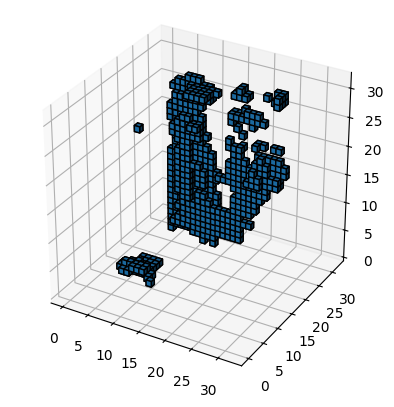

In [129]:
# -*- coding: utf-8 -*-
#
# Developed by Haozhe Xie <cshzxie@gmail.com>

import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D

def get_volume_views(volume):
    volume = volume.squeeze().__ge__(0.5)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')  # Correct way to set up 3D axes
    ax.set_aspect('equal')
    ax.voxels(volume, edgecolor="k")
    
    # Display the generated plot in the notebook cell output
    plt.show()
    plt.close()

# Detach the tensor from the computation graph and convert it to a NumPy array
gv = generated_volume.detach().cpu().numpy()

# Display the voxel plot
get_volume_views(gv)


32
torch.Size([32, 32])


ValueError: Argument filled must be 3-dimensional

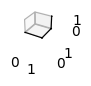

In [93]:
import matplotlib.pyplot as plt

def visualize_channels(volume):
    num_channels = volume.shape[2]  # Number of channels
    print(num_channels)
    fig = plt.figure(figsize=(15, 5))

    for i in range(num_channels):
        ax = fig.add_subplot(1, num_channels, i + 1, projection='3d')
        channel_data = volume.squeeze().__ge__(0.5)  # Apply threshold
        channel_data = channel_data[i]
        print(channel_data.shape)
        ax.voxels(channel_data, edgecolor='k')
        ax.set_title(f'Channel {i}')

    plt.tight_layout()
    plt.show()

# Assuming 'volume' is your tensor with shape [9, 32, 32, 32]
visualize_channels(output)


In [54]:
!pip install trimesh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.1/700.1 kB 4.2 MB/s eta 0:00:00a 0:00:01


In [60]:
import torch
import numpy as np
from skimage import measure
import trimesh

def tensor_to_obj(tensor, threshold=0.5, filename='model.obj'):
    # Ensure tensor is on CPU and convert to numpy array
    voxels = tensor.cpu().detach().numpy()
    
    # Remove batch and channel dimensions (from shape (1, 1, 9, 32, 32, 32) -> (9, 32, 32, 32))
    voxels = voxels.squeeze()
    
    # Ensure we are left with a (32, 32, 32) shape
    if voxels.shape == (9, 32, 32, 32):
        # Apply marching cubes to each 3D slice (32, 32, 32)
        vertices, faces, _, _ = measure.marching_cubes(voxels[1], threshold)  # Assuming first slice for demo
        
        # Create a trimesh object
        mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
        
        # Save as OBJ
        mesh.export(filename)
        
        print(f"Model saved as {filename}")
    else:
        print(f"Unexpected shape after squeezing: {voxels.shape}")

# Example usage
# Assuming `output` is your tensor with shape (1, 1, 9, 32, 32, 32)
tensor_to_obj(output, filename='3d_mnist_model.obj')


Model saved as 3d_mnist_model.obj


In [ ]:









# print(Model)


# img=img.convert_to_tensor()



# x=torch.randn(1,1,3, 224, 224)
# print(x.shape)
# print(Model(x).shape)


In [10]:
import cv2 as cv

In [36]:
img=cv.imread("/kaggle/input/bbbbbbbb/0093.png")

In [37]:
type(img)

numpy.ndarray

In [38]:
img.shape

(500, 379, 3)

In [39]:
img=cv.resize(img,(224,224))

In [40]:
type(img)

numpy.ndarray

In [41]:
img=img.view(-1,224,224)

TypeError: view() takes from 0 to 2 positional arguments but 3 were given

In [33]:
img=img.float()

In [35]:
type(img)

torch.Tensor

In [44]:

# img=img.convert_to_tensor()
# img=torch.from_numpy(img).float()

img=img.unsqueeze(0).unsqueeze(0)

# x=torch.randn(1,1,3, 224, 224)
# print(x.shape)
# print(Model(x).shape)
print(encoder(img).shape)

AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

In [8]:
x=torch.rand(16,1,3,224,224)
encoder(x)

tensor([[[[[ 2.8042e+00,  4.6067e-01,  9.3434e-01,  ..., -2.2924e-01,
            -1.6860e-01,  7.5713e-01],
           [ 7.0829e-02,  7.3486e-01, -5.8765e-01,  ...,  1.1128e+00,
            -3.1826e-01,  8.3921e-01],
           [-3.8712e-01,  1.0639e+00, -7.0990e-01,  ...,  2.3116e-01,
            -1.3939e-01,  1.1504e+00],
           ...,
           [ 2.3133e-01, -7.6070e-01, -2.4583e-01,  ...,  7.6493e-01,
            -5.5759e-01,  2.6145e+00],
           [ 1.1542e+00, -5.0894e-01, -4.7033e-01,  ..., -6.3919e-01,
             6.0548e-01,  1.2903e+00],
           [ 2.3429e-01,  4.9251e-01,  1.6428e+00,  ..., -8.6822e-01,
            -3.2450e-01, -5.0321e-01]],

          [[-8.4073e-01,  4.3254e-02, -4.1820e-01,  ...,  1.2874e+00,
             7.9539e-02,  2.5669e+00],
           [ 1.0433e+00, -2.6519e-01,  9.6795e-01,  ...,  9.0870e-01,
            -2.8022e-01, -3.8838e-01],
           [ 7.9655e-01, -7.2384e-01, -2.8887e-03,  ..., -7.4136e-01,
             3.7464e-01, -4.2114e-01],
 